In [8]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os
fontsize = 16


sns.set_context("paper", rc={
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": fontsize,
    'ytick.labelsize': fontsize,
    'grid.linewidth': 1.5,
})
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plt.rc('font', family='Times New Roman', weight='bold', size=fontsize)
# plt.rc('lines', lw=3.5)
plt.rcParams.update(
    {'font.size': fontsize, "axes.grid": True, 'grid.linestyle': '-.'})


path_mac = "/Users/jairwu/resources/FaaS/batching-request/test/asplos/dispatch_interval_sensitivity/results/io"
path_linux = "."
PATH = utils.get_data_path(path_mac=path_mac, path_linux=path_linux)
PLOT_DIR = '../plots'
os.system(f"mkdir -p {PLOT_DIR}")
FIGSIZE = (4.5, 2.5)
sns.color_palette("Blues")
pal = sns.color_palette("Blues")
display(pal)
mypal = pal.as_hex()[2:]
print(mypal)


[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

['#89bedc', '#539ecd', '#2b7bba', '#0b559f']


In [9]:
import numpy as np
all_csvs = list(
    map(lambda x: f'{x.split(".csv")[0]}', glob.glob(f"{PATH}/num_container*.csv")))
strategies = ['BaseBatching', "Kraken", "SFS",  "s_Batching"]
legends = ['Vanilla', "Kraken", "SFS",  "FaaSBatch"]
strategy_csvs = {
    strategy: list(filter(lambda x: strategy in x, all_csvs)) for strategy in strategies
}

data = pd.DataFrame()
for strategy, csvs in strategy_csvs.items():
    for csv in csvs:
        df = pd.read_csv(f"{csv}.csv")
        dispatch_interval = csv.split("_")[-1]
        df['dispatch_interval'] = dispatch_interval
        if strategy == 's_Batching':
            df['strategy'] = "FaaSBatch"
        elif strategy == "BaseBatching":
            df['strategy'] = 'Vanilla'
        else:
            df['strategy'] = strategy
        data = pd.concat([df, data])


#####启动容器数量评估######
SFS 平均启动的容器数量为：243.5 个, FaaSBatch 比其少了 93.22381930184805%，共计 16.5 个
Kraken 平均启动的容器数量为：65.0 个, FaaSBatch 比其少了 74.61538461538461%，共计 16.5 个
Vanilla 平均启动的容器数量为：254.0 个, FaaSBatch 比其少了 93.50393700787401%，共计 16.5 个


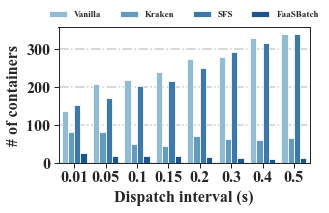

In [10]:
def bar_plot(y, y_label):
    fig, ax1 = plt.subplots(figsize=FIGSIZE)
    sns.barplot(x="dispatch_interval", y=y, hue="strategy", hue_order=legends,
                data=data, palette=mypal, order=sorted(data['dispatch_interval'].unique()))
    data['strategy'].unique()
    sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                    ncol=4, title=None, frameon=False, fontsize=fontsize-7)
    ax1.set_ylabel(y_label, weight='bold')
    ax1.set_xlabel("Dispatch interval (s)", weight='bold')
    return fig


fig = bar_plot(y="num_containers", y_label="# of containers")
fig.savefig(f"{PLOT_DIR}/numOfContainersAcrossDispatchIntervalsIO.pdf",
            dpi=800, bbox_inches='tight', format='pdf')
strategies = data['strategy'].unique()
num_container_mean_across_interval = {}
num_container_mean_across_interval = {
    strategy: [] for strategy in strategies
}

print("#####启动容器数量评估######")
# 统计数据
for interval, df in data.groupby("dispatch_interval"):
    aux_group = df.groupby("strategy")
    num_containers_mean = aux_group['num_containers'].mean()
    # print(f"\nDisaptch interval 为 {interval} 时:")
    for strategy in strategies:
        num_container_mean_across_interval[strategy].append(
            num_containers_mean[strategy])

num_containers_FaaSBatch = num_container_mean_across_interval['FaaSBatch']
avg_containers_FaaSBatch = sum(
    num_containers_FaaSBatch) / len(num_containers_FaaSBatch)

for strategy, num_containers_mean in num_container_mean_across_interval.items():
    if strategy == "FaaSBatch":
        continue
    avg_num_contaienrs = sum(num_containers_mean) / len(num_containers_mean)
    print(f"{strategy} 平均启动的容器数量为：{avg_num_contaienrs} 个, FaaSBatch 比其少了 {100*(avg_num_contaienrs - avg_containers_FaaSBatch)/avg_num_contaienrs}%，共计 {avg_containers_FaaSBatch} 个")


# for strategy, num_containers_mean in num_container_mean_across_interval.items():
#     print(f"{strategy} 平均启动的容器数量为：{sum(num_containers_mean)/ len(num_containers_mean)} 个")
